# Q Learning with varying Epsilon.

In this notebook, We build upon the same premise as before in the `Q_Learning_from_Scratch.ipynb` and build further.

- We used a total of 10,000 episodes and saw amazing results, however our value of episilon was fixed to 0.3
- In this notebook, our goal is to initialize epsilon value to a large value and then stedily decrease it with increasing number of episodes.
- This will allow us to explore more during the initialize phase of the training and exploit more during the later phase of the training.

## Previous updated code

- I removed the global epsilon value and later introduced `EPSILON_START` and `EPSILON_END`.
- Updated `choose_action` function to accept `epsilon` as a parameter, since it's no longer defined globally.

In [6]:
import numpy as np 
import random 

GRID_SIZE = 4
START = (3,0)
GOAL = (3,3)

OBSTACLES = [(2, 1), (2, 2), (3,2)]

# Actions:
ACTIONS = {  # (row, col)
    'UP': (-1, 0),
    'DOWN': (1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, 1)
}

In [7]:
def is_valid_state(state: tuple[int, int]) -> bool:
    x, y = state
    return (0 <= x < GRID_SIZE and 
            0 <= y < GRID_SIZE and 
            (x, y) not in OBSTACLES)

def generate_next_state(state: tuple[int, int], action: str) -> tuple[int, int]:
    x, y = state
    if action not in ACTIONS:
        raise ValueError(f"Invalid action: {action}")
    next_state = (x + ACTIONS[action][0], y + ACTIONS[action][1])
    return next_state if is_valid_state(next_state) else state

def reward_function(state: tuple[int,int], next_state: tuple[int, int]) -> int:
    if next_state == GOAL:
        return 100
    elif next_state in OBSTACLES or next_state == state:
        return -10
    return -1

In [8]:
def choose_action(state: tuple[int, int], q_table: dict, epsilon: float) -> str:
    # With probability ε, explore; otherwise pick best-known action
    if random.random() < epsilon:
        return random.choice(list(ACTIONS))
    else:
        state_q_values = q_table.get(state, {})
        if state_q_values:
            return max(state_q_values, key=state_q_values.get)
        return random.choice(list(ACTIONS))

In [9]:
def update_q_table(q_table: dict, state: tuple[int, int], action: str, reward: int, next_state: tuple[int, int]) -> None:
    q_table.setdefault(state, {})
    current_q = q_table[state].get(action, 0.0)
    next_q = max(q_table.get(next_state, {}).values(), default=0.0)
    q_table[state][action] = current_q + ALPHA * (reward + GAMMA * next_q - current_q)

## New Code

- Inside each episode, `epsilon` is computed as `epsilon = EPSILON_START - episode * ((EPSILON_START - EPSILON_END) / (EPISODES - 1))`

In [5]:
def train_agent() -> dict:
    q_table = {}

    for episode in range(EPISODES):
        # Linear decay of ε from 0.9 down to 0.1
        epsilon = EPSILON_START - episode * ((EPSILON_START - EPSILON_END) / (EPISODES - 1))
        
        state = START
        while state != GOAL:
            action = choose_action(state, q_table, epsilon)
            next_state = generate_next_state(state, action)
            reward = reward_function(state, next_state)
            update_q_table(q_table, state, action, reward, next_state)
            state = next_state

    return q_table

In [20]:
ALPHA = 0.2       # Learning rate
GAMMA = 0.9       # Discount factor
EPISODES = 50   # Total episodes

# Epsilon schedule parameters
EPSILON_START = 0.9
EPSILON_END = 0.1

In [21]:
q_table = train_agent()

## Visualize

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_q_table_as_grid(q_table: dict) -> None:
    """Visualize the Q-table as a grid with all action values for each state using matplotlib."""
    fig, axes = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(2*GRID_SIZE, 2*GRID_SIZE))
    action_names = list(ACTIONS.keys())
    action_symbols = {'UP': '^', 'DOWN': 'v', 'LEFT': '<', 'RIGHT': '>'}
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax = axes[i, j]
            ax.set_xticks([])
            ax.set_yticks([])
            state = (i, j)
            ax.set_facecolor('white')
            if state == GOAL:
                ax.set_facecolor('#b6e3b6')
                ax.text(0.5, 0.5, "GOAL", ha='center', va='center', fontsize=14, fontweight='bold')
            elif state in OBSTACLES:
                ax.set_facecolor('#e3b6b6')
                ax.text(0.5, 0.5, "OBSTACLE", ha='center', va='center', fontsize=10, fontweight='bold')
            else:
                q_vals = q_table.get(state, {})
                # Draw arrows and values for each action
                for action, (dx, dy) in ACTIONS.items():
                    q = q_vals.get(action, 0.0)
                    if action == 'UP':
                        ax.annotate(f"{q:.1f}", (0.5, 0.85), ha='center', va='center', color='blue', fontsize=10)
                        ax.annotate(action_symbols[action], (0.5, 0.95), ha='center', va='center', color='blue', fontsize=12)
                    elif action == 'DOWN':
                        ax.annotate(f"{q:.1f}", (0.5, 0.15), ha='center', va='center', color='green', fontsize=10)
                        ax.annotate(action_symbols[action], (0.5, 0.05), ha='center', va='center', color='green', fontsize=12)
                    elif action == 'LEFT':
                        ax.annotate(f"{q:.1f}", (0.15, 0.5), ha='center', va='center', color='purple', fontsize=10)
                        ax.annotate(action_symbols[action], (0.05, 0.5), ha='center', va='center', color='purple', fontsize=12)
                    elif action == 'RIGHT':
                        ax.annotate(f"{q:.1f}", (0.85, 0.5), ha='center', va='center', color='orange', fontsize=10)
                        ax.annotate(action_symbols[action], (0.95, 0.5), ha='center', va='center', color='orange', fontsize=12)
            ax.set_title(f"({i},{j})", fontsize=10)
    plt.suptitle("Q-table Visualization (All Actions)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def visualize_best_actions_grid(q_table: dict) -> None:
    """Visualize the best action and its Q-value for each state in a grid using matplotlib."""
    fig, ax = plt.subplots(figsize=(1.5*GRID_SIZE, 1.5*GRID_SIZE))
    ax.set_xlim(-0.5, GRID_SIZE-0.5)
    ax.set_ylim(-0.5, GRID_SIZE-0.5)
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1))
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, which='both', color='black', linewidth=1)
    action_symbols = {'UP': '^', 'DOWN': 'v', 'LEFT': '<', 'RIGHT': '>'}
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            state = (i, j)
            if state == GOAL:
                ax.add_patch(plt.Rectangle((j-0.5, GRID_SIZE-1-i-0.5), 1, 1, color='#b6e3b6'))
                ax.text(j, GRID_SIZE-1-i, "GOAL", ha='center', va='center', fontsize=14, fontweight='bold')
            elif state in OBSTACLES:
                ax.add_patch(plt.Rectangle((j-0.5, GRID_SIZE-1-i-0.5), 1, 1, color='#e3b6b6'))
                ax.text(j, GRID_SIZE-1-i, "OBSTACLE", ha='center', va='center', fontsize=10, fontweight='bold')
            else:
                state_q_values = q_table.get(state, {})
                if state_q_values:
                    best_action = max(state_q_values, key=state_q_values.get)
                    best_q_value = state_q_values[best_action]
                    symbol = action_symbols[best_action]
                    ax.text(j, GRID_SIZE-1-i+0.15, symbol, ha='center', va='center', fontsize=22, color='black')
                    ax.text(j, GRID_SIZE-1-i-0.18, f"{best_q_value:.1f}", ha='center', va='center', fontsize=10, color='blue')
                else:
                    ax.text(j, GRID_SIZE-1-i, "N/A", ha='center', va='center', fontsize=10, color='gray')
            ax.text(j, GRID_SIZE-1-i-0.38, f"({i},{j})", ha='center', va='center', fontsize=8, color='gray')
    plt.title("Best Action per State (Q-table)", fontsize=16)
    plt.show()

# Results

In [22]:
q_table = train_agent()

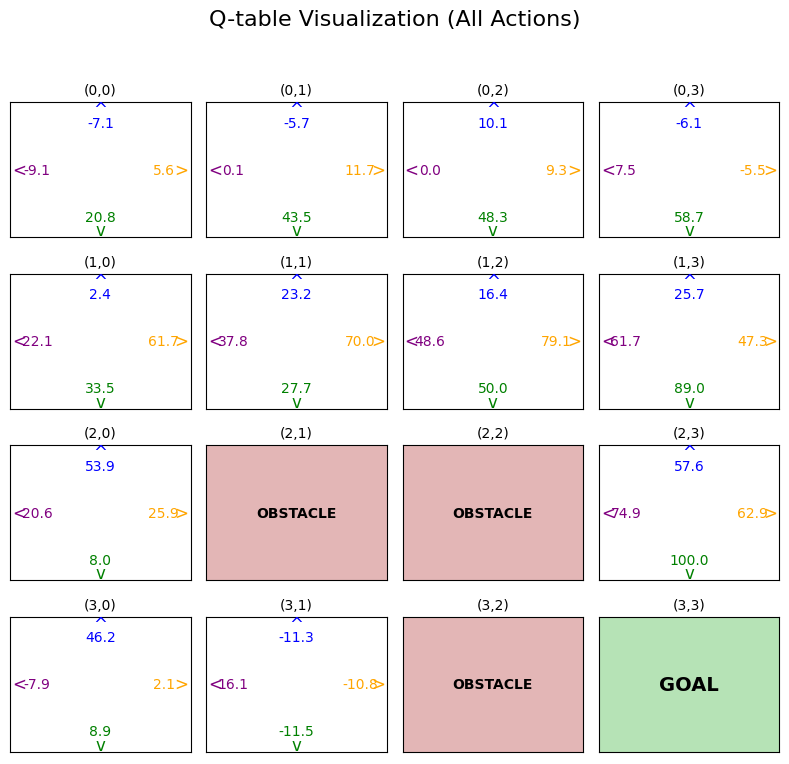

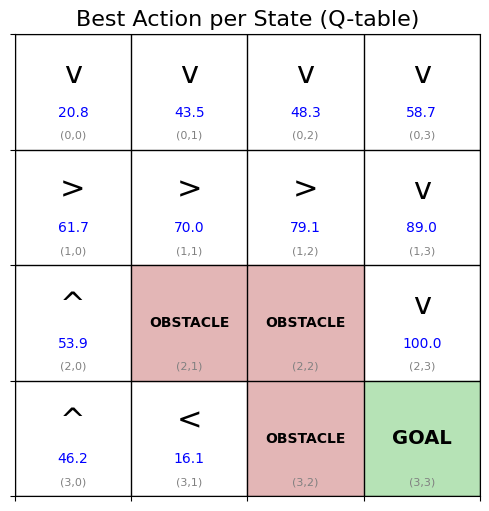

In [23]:
# Visualize the Q-table as a grid
visualize_q_table_as_grid(q_table)

# Visualize the best actions and their Q-values in a grid
visualize_best_actions_grid(q_table)